# Chronos Time Series Forecasting

In [3]:
import pandas as pd
import numpy as np

## Load Dataset
In this dataset visitors are precalculated, with the same way as in the other notebooks.

In [ ]:
df = pd.read_csv('/Users/fanisbak/Documents/visitors.csv')
df = df[['datetime', 'visitors']]

* Split dataset based on a datetime value

In [34]:
# Ensure datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Create train and test DataFrames using boolean masks
train_df = df[:-64]
test_df = df[-64:]

# Forecasting
We use `chronos-t5-base` model, which is the best one made by Chronos.

In [35]:
import torch
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# quantiles is an fp32 tensor with shape [batch_size, prediction_length, num_quantile_levels]
# mean is an fp32 tensor with shape [batch_size, prediction_length]
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(train_df["visitors"]),
    prediction_length=64,
    quantile_levels=[0.1, 0.5, 0.9]
)

* Now, we plot the forecast.

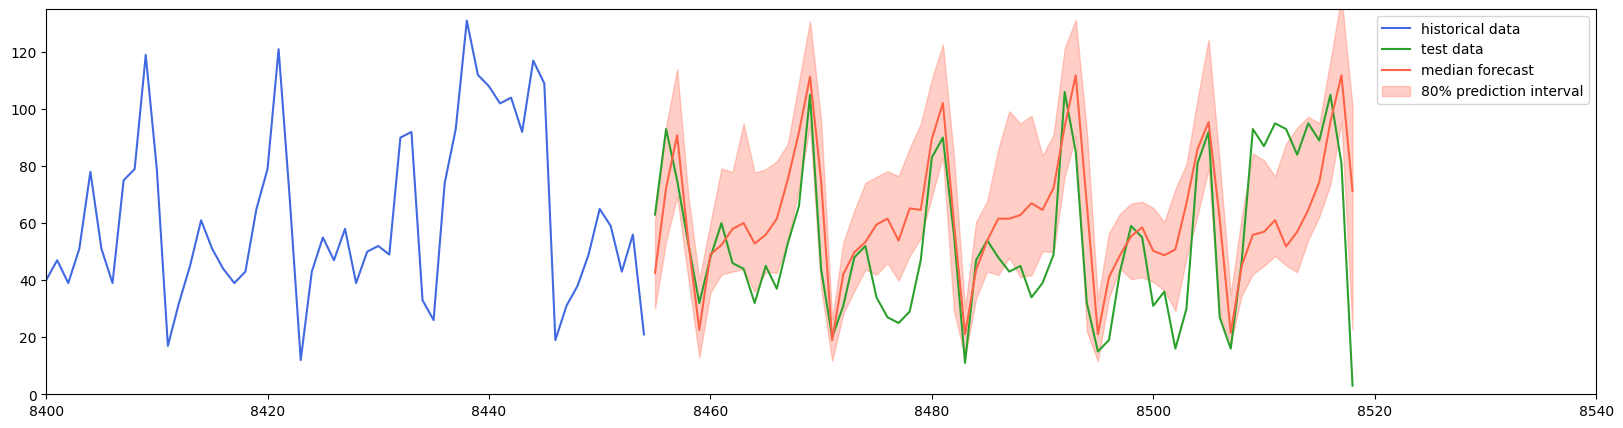

In [36]:
import matplotlib.pyplot as plt

forecast_index = range(len(train_df), len(train_df) + 64)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(20, 5))
plt.plot(train_df["visitors"], color="royalblue", label="historical data")
plt.plot(test_df["visitors"],color="tab:green", label="test data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.xlim(8400,8540)
plt.ylim(0, 135)
#plt.xlim(0,72)
#plt.grid()
plt.show()

# Evaluation
We use `Mean Abspolute Error (MAE)` for the evaluation of the model.

In [39]:
print('Mean Absolut Error\nMAE:', np.mean(np.abs(test_df["visitors"].values[:64] - median.numpy())))

Mean Absolut Error
MAE: 18.184363543987274
